In [1]:
pip install umap-learn 

Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd # Datafram
import numpy as np # Array and math
import matplotlib.pylab as plt # Plot
import umap  # pip install umap-learn 
import io # Path
import re # Replace string to clean data
import nltk # Using stopwords
nltk.download('stopwords')
nltk.download('punkt')
import time # Measure time
from nltk.tokenize import word_tokenize # Tokenize text
from nltk.stem import PorterStemmer # Filler out the short word
from nltk.corpus import stopwords # Stopwords
from sklearn.manifold import TSNE # T-sne algorithm
from sklearn.metrics import accuracy_score # Check algorithm is good or not
from sklearn.metrics import silhouette_score # Evaluate result
from sklearn.cluster import KMeans # Cluster data after embedding
from umap import validation # Trustworthiness_umap
from warnings import filterwarnings # Delete warning

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## In this notebook
- Read data from kaggle having information about film.
- Select some necessary columns and clean them. Especially, text data is embeded by using pre-train model from glove.
- Use umap and t-sne to reduce dimensionality.
- Use K-means to cluster data before and after reducing.
- Visualize and use silhouette_score, trustworthiness_umap to evaluate

In [14]:
def load_data(path):
    df = pd.read_csv(path) # Read data from path
    return df


def select_column(df, text_data):
    X = pd.DataFrame()
    X['text'] = text_data.apply(lambda x: text_cleaner(x))
    X['IMDB_Rating'] = df['IMDB_Rating']
    X['No_of_Votes'] = df['No_of_Votes']
    X['Released_Year'] = df['Released_Year'].replace('PG', '1943').astype(int)
    X['Runtime'] = df['Runtime'].apply(lambda x: int(x[:-4]))
    return X


def eleminate_not_word(text):
    cleaner = re.sub(r"[^a-zA-Z ]+", ' ', text.lower()) # Lowercase and strip everything except words
    return cleaner


def tokenize(text):
    cleaner = word_tokenize(text) # Tokenize text to words
    return cleaner


def eleminate_stop_word_and_padding(text):
    stopWords = set(stopwords.words('english')) # Download stopwords English from nltk
    ps = PorterStemmer() # Initial filler out short words
    clean = []
    for w in text:
        # filter out stopwords
        if w not in stopWords:
            # filter out short words
            if len(w) > 2:
                # Stem 
                clean.append(ps.stem(w))
    return clean


def text_cleaner(text):
    only_word = eleminate_not_word(text)
    token_word = tokenize(only_word)
    clean_text = eleminate_stop_word_and_padding(token_word)
    return clean_text


def load_word_embeddings(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') # Read file
    vocab, matrix = [], []
    for line in fin: # Each line
        tokens = line.rstrip().split(' ') # Tokenize
        vocab.append(tokens[0]) # Add vocab
        matrix.append(list(map(float, tokens[1:]))) # Add embedding
    return vocab, matrix


def get_embedding_glove():
#     !wget http://nlp.stanford.edu/data/glove.6B.zip # Download glove
#     !unzip glove.6B.zip # Unzip or extract file
    vocab, matrix = load_word_embeddings("glove.6B.100d.txt") # Get embedding matrix with glove have 100 dim
    embedding_matrix = np.pad(matrix, ((2,0),(0,0)), mode='constant', constant_values =0.0)  # Padding to equal length
    return vocab, embedding_matrix


def text_to_index(tokenized_texts, vocab, unknown_word):
    X = [] # Contain index of all text
    word_to_index = {word: index+2 for index, word in enumerate(vocab)}

    for text in tokenized_texts: # For each text
        cur_text_indices = [] # Contain index of a text 
        for word in text: # For each word
            if word in word_to_index:
                cur_text_indices.append(word_to_index[word])    
            else:
                cur_text_indices.append(unknown_word)       
        X.append(cur_text_indices) # Append index of text 
    return X


def get_index_embedding(tokenized_texts, vocab, matrix):
    X = text_to_index(tokenized_texts, vocab, 1) # Convert our text to index using above embedding matrix
    return X


def get_embedding_matrix(X, embedding_matrix):
    text_embedding = [] 
    for text_index in X: # Each text
        embeddings = []
        for word_index in text_index: # Each word
            embeddings.append(embedding_matrix[word_index]) # Get embedding vector from pre-train model
        text_embedding.append(np.mean(embeddings, axis=0)) # Using mean for all vector of text
    return np.array(text_embedding)


def concat_data(col_1, col_2):
    concat_data = np.hstack((col_1, col_2))
    return concat_data


def umap_reduce_dim(X):
    manifold = umap.UMAP(
              n_neighbors=30,
              min_dist=0.1,
              n_components=2,
              metric='cosine',
              random_state=62
              )
    X_reduced = manifold.fit_transform(X)
    return X_reduced


def plot_scatter(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=2, cmap='Spectral')
    plt.show()

    
def t_sne_reduce_dim(X):
    tsne = TSNE(n_components=2, perplexity=30, verbose=1, random_state=123)
    X_reduced = tsne.fit_transform(np.array(X))
    return X_reduced
  
    
def concatenate_text(data):
    return data['Series_Title'] + data['Genre']+ data['Overview']+ data['Director']


def k_means(X):
    kmeans = KMeans(n_clusters=20, random_state=62, n_init="auto").fit(X)
    label_kmeans = kmeans.labels_
    return label_kmeans


def evaluation(X, y_pred, y_not_reduce):
    acc = accuracy_score(y_not_reduce, y_pred)
    score_sil = silhouette_score(X, y_not_reduce)
    return acc, score_sil

In [4]:
path = '/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv'

In [5]:
# Load data
df = load_data(path)
text_data = concatenate_text(df)
X = select_column(df, text_data)
X

,text,IMDB_Rating,No_of_Votes,Released_Year,Runtime
0,"[shawshank, redemptiondramatwo, imprison, men,...",9.3,2343110,1994,142
1,"[godfathercrim, dramaan, organ, crime, dynasti...",9.2,1620367,1972,175
2,"[dark, knightact, crime, dramawhen, menac, kno...",9.0,2303232,2008,152
3,"[godfath, part, iicrim, dramath, earli, life, ...",9.0,1129952,1974,202
4,"[angri, mencrim, dramaa, juri, holdout, attemp...",9.0,689845,1957,96
...,...,...,...,...,...
995,"[breakfast, tiffani, scomedi, drama, romancea,...",7.6,166544,1961,115
996,"[giantdrama, westernsprawl, epic, cover, life,...",7.6,34075,1956,201
997,"[eternitydrama, romanc, warin, hawaii, privat,...",7.6,43374,1953,118
998,"[lifeboatdrama, warsever, survivor, torpedo, m...",7.6,26471,1944,97


In [9]:
# Get embedding from glove
vocab, embedding_matrix = get_embedding_glove() # Get embedding matrix from glove

In [10]:
# Embed text data
tokenized_texts = X['text'].to_list()
X_index = get_index_embedding(tokenized_texts, vocab, embedding_matrix)
text_embedding = get_embedding_matrix(X_index, embedding_matrix)

In [11]:
# Get other feature and concat
other_feature = np.array(X.drop('text', axis=1)).reshape(1000, -1)
concatenated_data = concat_data(text_embedding, other_feature)
other_feature.shape

(1000, 4)

In [12]:
# Concat all feature
concatenated_data = np.hstack((text_embedding, other_feature))
concatenated_data.shape

(1000, 104)

In [15]:
# Using k-mean not having reduce dimension method
label_only_kmeans = k_means(concatenated_data)

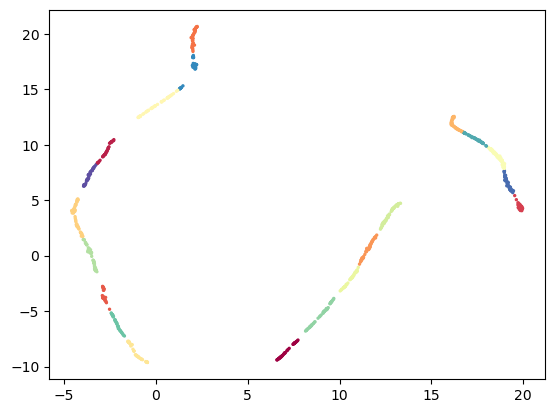

In [25]:
# Using umap and kmeans
X_reduced_umap = umap_reduce_dim(concatenated_data)
label_kmeans_umap = k_means(X_reduced_umap)
plot_scatter(X_reduced_umap, label_kmeans_umap)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2121.502710
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.118217
[t-SNE] KL divergence after 1000 iterations: 0.184966


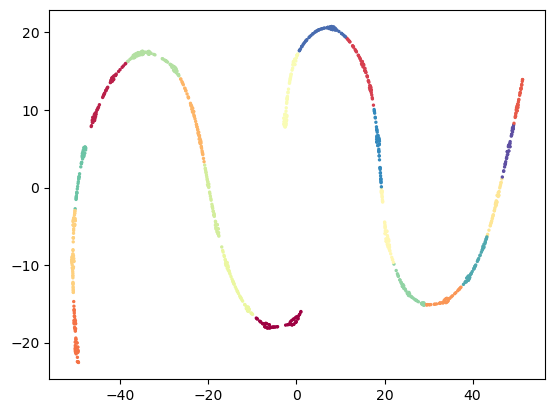

In [26]:
# Using tsne and kmeans
X_reduced_tsne = t_sne_reduce_dim(concatenated_data)
label_kmeans_tnse = k_means(X_reduced_tsne)
plot_scatter(X_reduced_tsne, label_kmeans_tnse)

In [18]:
acc_tsne, score_tsne = evaluation(X_reduced_tsne, label_kmeans_tnse, label_only_kmeans)
print("Ratio of difference between dimensionality reduction and non-dimension of t-sne: ", acc_tsne)
print("Score silhouette of t-sne:", score_tsne)

Ratio of difference between dimensionality reduction and non-dimension of t-sne:  0.108
Score silhouette of t-sne: 0.4376191


In [24]:
acc_umap, score_umap = evaluation(X_reduced_umap, label_kmeans_umap, label_only_kmeans)
print("Ratio of difference between dimensionality reduction and non-dimension of umap: ", acc_umap)
print("Score silhouette of umap:", score_umap)

Ratio of difference between dimensionality reduction and non-dimension of umap:  0.097
Score silhouette of umap: 0.42916667


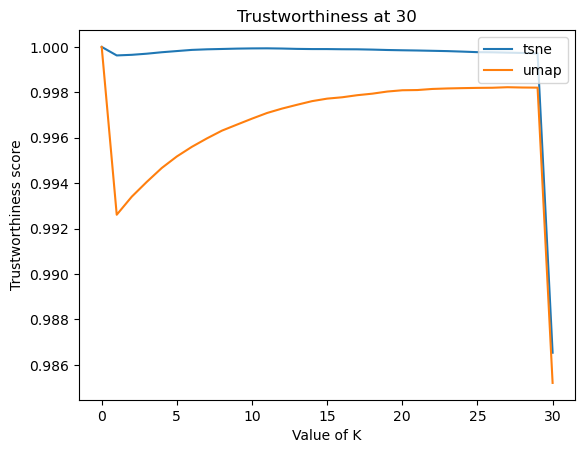

In [27]:
K = 30
filterwarnings('ignore')

trustworthiness_tsne = validation.trustworthiness_vector(source=concatenated_data
                                  ,embedding=X_reduced_tsne
                                  ,max_k=K)
trustworthiness_umap = validation.trustworthiness_vector(source=concatenated_data
                                  ,embedding=X_reduced_umap
                                  ,max_k=K)

filterwarnings('default')


plt.plot(trustworthiness_tsne)
plt.plot(trustworthiness_umap)
plt.ylabel("Trustworthiness score")
plt.xlabel("Value of K")
plt.title(f"Trustworthiness at {K}")
plt.legend(["tsne", "umap"], loc="upper right")